# Malaria Detection


## Importing the libraries and the dataset

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = './cell_images'
train_path = data_dir + '/train'
test_path = data_dir + '/test'
os.listdir(data_dir)

['.DS_Store', 'test', 'train']

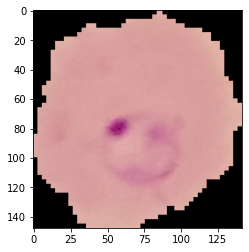

In [2]:
parasitized_cell = './cell_images/train/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
plt.imshow(imread(parasitized_cell))

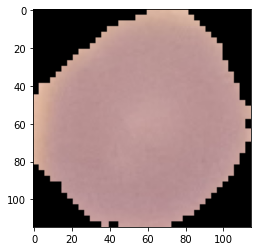

In [3]:
uninfected_cell = './cell_images/train/uninfected/C1_thinF_IMG_20150604_104722_cell_9.png'
plt.imshow(imread(uninfected_cell))

In [4]:
print('Parasitized training data ' + str(len(os.listdir(train_path+'/parasitized'))))
print('Uninfected training data ' + str(len(os.listdir(train_path+'/uninfected'))))
print('Parasitized testing data ' + str(len(os.listdir(test_path+'/parasitized'))))
print('Uninfected testing data ' + str(len(os.listdir(test_path+'/uninfected'))))

Parasitized training data 12480
Uninfected training data 12480
Parasitized testing data 1300
Uninfected testing data 1300


In [5]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path + '/uninfected'):
  img = imread(test_path+'/uninfected/'+ image_filename)
  d1, d2, color = img.shape
  dim1.append(d1)
  dim2.append(d2)

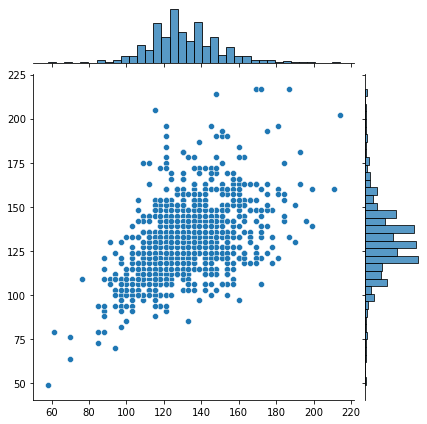

In [6]:
sns.jointplot(x = dim1, y = dim2)

In [7]:
np.mean(dim1)

130.92538461538462

In [8]:
np.mean(dim2)

130.75

In [9]:
image_shape=(130, 130, 3)

## Data Pre-processing

In [10]:
image_gen = ImageDataGenerator(rescale = 1/255, 
                               rotation_range = 20,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')

# rotation_range specifies the degree of rotation of images
# width_shift_range changes the width of the image by stretchinng it horizontally
# height_shift_range changes the height of the image by stretching it vertically
# shear_range specifies the amount of image that can be cropped/removed
# zoom_range specifies the amount by which the image can be zoomed in
# horizontal_flip specifies if the developer wants to flip the images horizontally
# fill_mode specifies which method the user wants to use to fill the missing data in the image

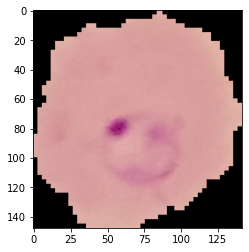

In [11]:
parasitized_img=imread(parasitized_cell)
plt.imshow(parasitized_img)

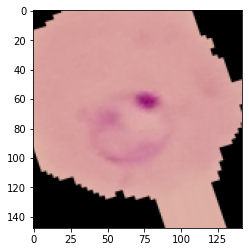

In [12]:
plt.imshow(image_gen.random_transform(parasitized_img))

In [13]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [14]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Model Creation

In [15]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = image_shape))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = image_shape))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = image_shape))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2024-01-30 23:09:48.212607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [17]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

batch_size = 16

train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size = image_shape[:2],
                                                color_mode = 'rgb',
                                                batch_size = batch_size,
                                                class_mode = 'binary',
                                                shuffle = True)

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size = image_shape[:2],
                                               color_mode = 'rgb',
                                               batch_size = batch_size,
                                               class_mode = 'binary',
                                               shuffle = False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [18]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [19]:
results = model.fit(train_image_gen,
                    epochs = 20,
                    validation_data = test_image_gen,
                    callbacks = [early_stopping])

Epoch 1/20
1560/1560 [==============================] - 431s 276ms/step - loss: 0.5148 - accuracy: 0.7532 - val_loss: 0.4283 - val_accuracy: 0.8396
Epoch 2/20
1560/1560 [==============================] - 407s 261ms/step - loss: 0.2597 - accuracy: 0.9088 - val_loss: 0.2087 - val_accuracy: 0.9273
Epoch 3/20
1560/1560 [==============================] - 421s 270ms/step - loss: 0.2372 - accuracy: 0.9204 - val_loss: 0.2083 - val_accuracy: 0.9277
Epoch 4/20
1560/1560 [==============================] - 411s 263ms/step - loss: 0.2236 - accuracy: 0.9279 - val_loss: 0.1992 - val_accuracy: 0.9331
Epoch 5/20
1560/1560 [==============================] - 405s 259ms/step - loss: 0.2164 - accuracy: 0.9287 - val_loss: 0.2073 - val_accuracy: 0.9342
Epoch 6/20
1560/1560 [==============================] - 403s 258ms/step - loss: 0.2151 - accuracy: 0.9300 - val_loss: 0.1915 - val_accuracy: 0.9365
Epoch 7/20
1560/1560 [==============================] - 407s 261ms/step - loss: 0.2069 - accuracy: 0.9339 - val_

## Model Evaluation

<AxesSubplot:>

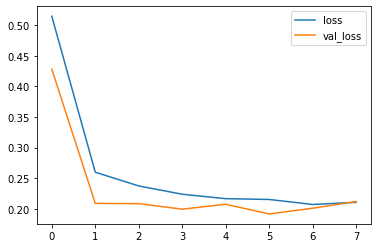

In [20]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [21]:
pred_probabilities = model.predict_generator(test_image_gen)
predictions = pred_probabilities > 0.5

print(classification_report(test_image_gen.classes,predictions))

/var/folders/tz/cmgxdlxd6gs28fryz21gdlzc0000gn/T/ipykernel_16296/3182972451.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_probabilities = model.predict_generator(test_image_gen)


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1300
           1       0.94      0.94      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [22]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1223,   77],
       [  75, 1225]])

## Predicting on an Image

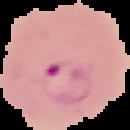

In [23]:
my_image = image.load_img(parasitized_cell,target_size=image_shape)
my_image

In [24]:
my_image = image.img_to_array(my_image)
my_image = np.expand_dims(my_image, axis=0)
model.predict(my_image)

array([[0.]], dtype=float32)